# Filter study for Cryoscope

**Goal**: find *correct* predistortion filters to apply to flux impulse

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy import special
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.signal import lfilter

from qibocal.protocols.two_qubit_interaction.cryoscope import _fit, _plot, CryoscopeData, CryoscopeType 

FULL_WAVEFORM = np.concatenate([np.zeros(10), np.ones(50), np.zeros(10)])


[Qibo 0.2.12|INFO|2024-12-10 18:14:11]: Loading platform dummy
[Qibo 0.2.12|INFO|2024-12-10 18:14:11]: Loading platform dummy


**Loading data**

In [2]:
def load_cryoscope_data(file_path: str, flux_pulse_amplitude: float) -> CryoscopeData:

    with np.load(file_path, allow_pickle=True) as npz_file:
        data_dict = {eval(key): value for key, value in npz_file.items()}
    
    return CryoscopeData(
        flux_pulse_amplitude=flux_pulse_amplitude,
        data=data_dict
    )

In [3]:
# Load data
data_path = Path.cwd().parent / "cryo_material" / "cryoscope" / "data" / "cryoscope-0"
results_json = data_path / "results.json"
data_json = data_path / "data.json"

with open(data_json, "r") as file:
    data = json.load(file)

with open(results_json, "r") as file:
    results = json.load(file)

print(data)
print(results)

{'"flux_pulse_amplitude"': 0.1}
{'"fitted_parameters"': {'["D1", "MX"]': [-0.00029639988763097147, 0.9259233868264589, 0.11297702572931177, 0.6811588111300295, 0.000200444727454511], '["D1", "MY"]': [-0.04330729231685593, 0.8053304242090724, 0.10001152244951339, -0.4561057364051088, 2.2940053954883843e-20]}, '"detuning"': {'"D1"': [0.0009089261001269961, 0.000771851252188812, 0.0006347764042506296, 0.0004977015563124541, 0.0006846099963171426, 0.0013814410767795885, 0.0009524330694135, 0.0020828945176104875, 0.00451965116963066, 0.008056748847200531, 0.010930627775662245, 0.01474036564921474, 0.01760471010827338, 0.018092453186971134, 0.018848063875241225, 0.019652778635600485, 0.020640357880029162, 0.020271250427942165, 0.020203698291166236, 0.020596376668128507, 0.020954302520328046, 0.021055945473469714, 0.020656135007137394, 0.019722949412587443, 0.018482234744427915, 0.017193251219308283, 0.016571813635514302, 0.01759950666098585, 0.018236536283483897, 0.0190546229767291, 0.019108

In [4]:
data_npz = np.load(data_path / "data.npz")
print(data_npz)

NpzFile '/home/elisa/Desktop/Qibo/Qibocal/cryo_material/cryoscope/data/cryoscope-0/data.npz' with keys: ["D1", "MX"], ["D1", "MY"]


#### Reproduce rectangular impulse response

In [5]:
flux_pulse_amplitude = data["\"flux_pulse_amplitude\""]

In [6]:
detuning = results["\"detuning\""]["\"D1\""]
rec_response = results["\"step_response\""]["\"D1\""]
print(type(detuning))
print(type(rec_response))

<class 'list'>
<class 'list'>


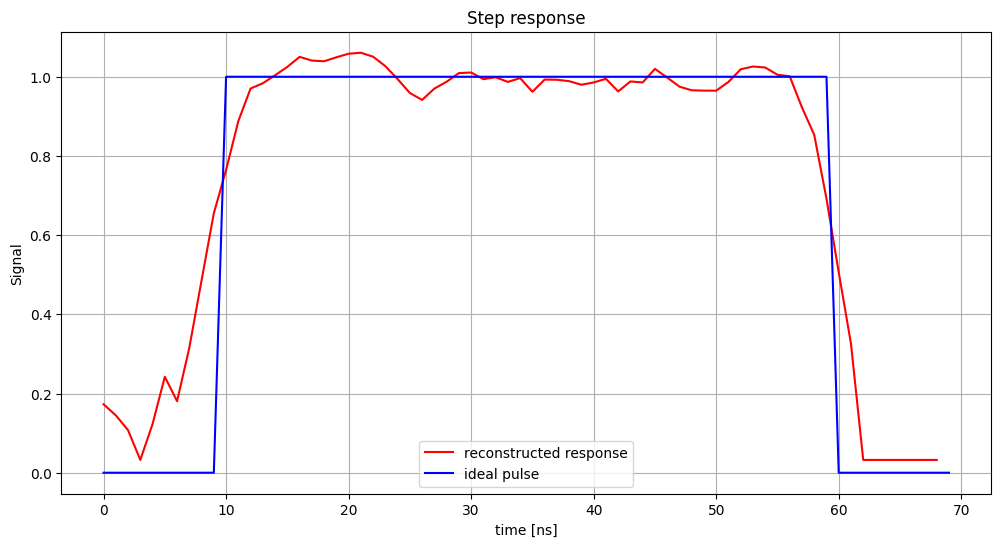

In [7]:
plt.figure(figsize=(12, 6)) 
plt.plot(rec_response, color = "red", label="reconstructed response")
plt.plot(FULL_WAVEFORM, color = "blue", label="ideal pulse")
plt.xlabel("time [ns]")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

### Definining filters on step function

In [8]:
def step(t):
    return np.ones_like(t)

t = np.arange(0,50,1)

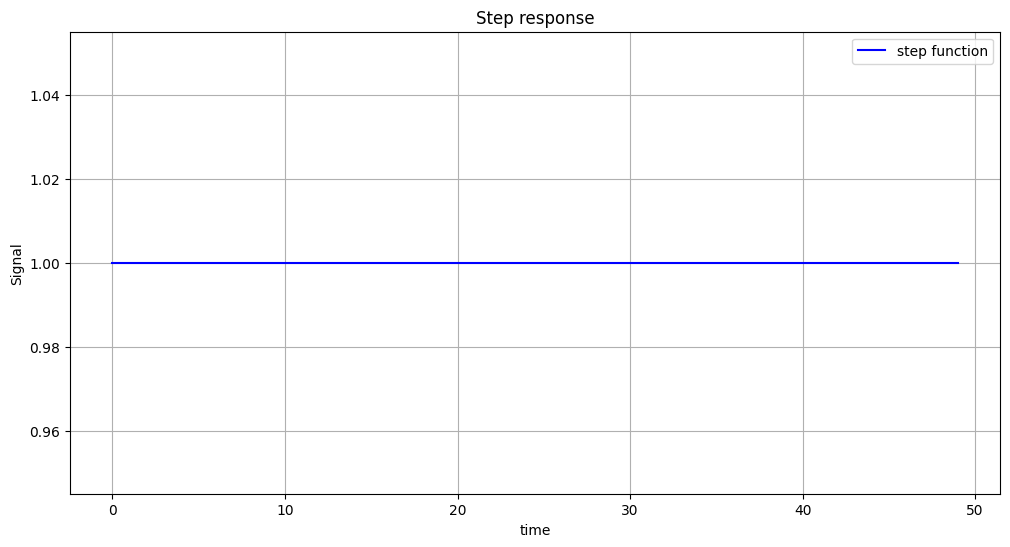

In [9]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, step(t), color = "blue", label="step function")
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [10]:
#Filters used in papaer for simulation

def bias_1(t, g, tau):
    return(g*(np.exp((-t)/tau))*step(t))

def bias_2(t, g, tau, A):
    return(g*(1 + A*np.exp(-t/tau)*step(t)))

def bias_3(t, g, tau, A):
    return(g*(1 + A*np.exp(-t/tau)*step(t)))

def skin_effect(t, g, alpha):
    return(g*(1-special.erfc(alpha*np.sqrt(t)/21)*step(t)))

def on_chip(t, g, tau, A):
    return(g*(1 + A*np.exp(-t/tau)*step(t)))

**Minimization with least squared method from scipy**

In [11]:
def model(params, t):
    g, tau, A = params
    return(g*(1 + A*np.exp(-t/tau)*step(t)))


def residuals(params, t, data):
    return model(params,t) - data

In [12]:
initial_guess = [1, 10, 1]
t = np.arange(0,50,1)
step_response = rec_response[10:60]

In [13]:
result = least_squares(residuals, initial_guess, args=(t, step_response))
print(result)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-4.591e-03  1.913e-02 ...  1.360e-01  2.973e-01]
           x: [ 9.893e-01  9.739e-01 -2.320e-01]
        cost: 0.07699982982485212
         jac: [[ 7.680e-01  0.000e+00  9.893e-01]
               [ 9.169e-01 -8.667e-02  3.543e-01]
               ...
               [ 1.000e+00  0.000e+00 -0.000e+00]
               [ 1.000e+00  0.000e+00 -0.000e+00]]
        grad: [-2.317e-10  1.396e-06  2.294e-09]
  optimality: 1.3958569216182548e-06
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 20
        njev: 16


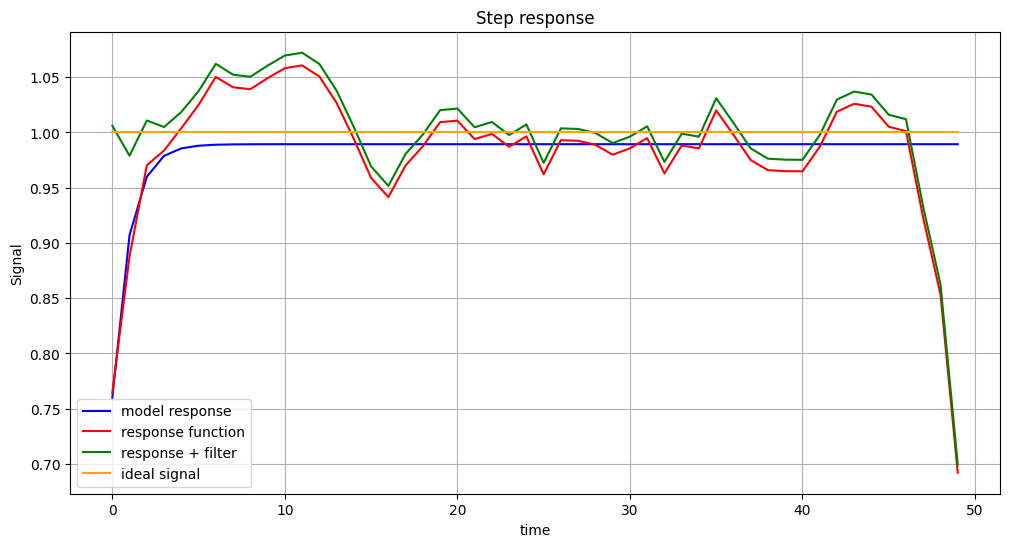

In [14]:
plt.figure(figsize=(12, 6)) 
plt.plot(t, model(result.x, t), color = "blue", label="model response")
plt.plot(step_response, color = "red", label="response function")
plt.plot(t, step_response/model(result.x,t), color = "green", label="response + filter" )
plt.plot(t, step(t), color = "orange", label="ideal signal" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

The article used 3 - 5 filters for this reason I should iterate this study on IIR for 3 - 5 times

In [15]:
init_guess = [1,10,1]
results = []
responses = []

for i in range(5):
    result = least_squares(residuals, initial_guess, args=(t, step_response)) #calcolo LSO
    results.append(result) #immagazzino risultato
    #init_guess = results[i].x #update init guess con stima da fit precedente
    step_response = step_response/model(result.x,t) #reference data update
    responses.append(step_response) #store data at each iteration

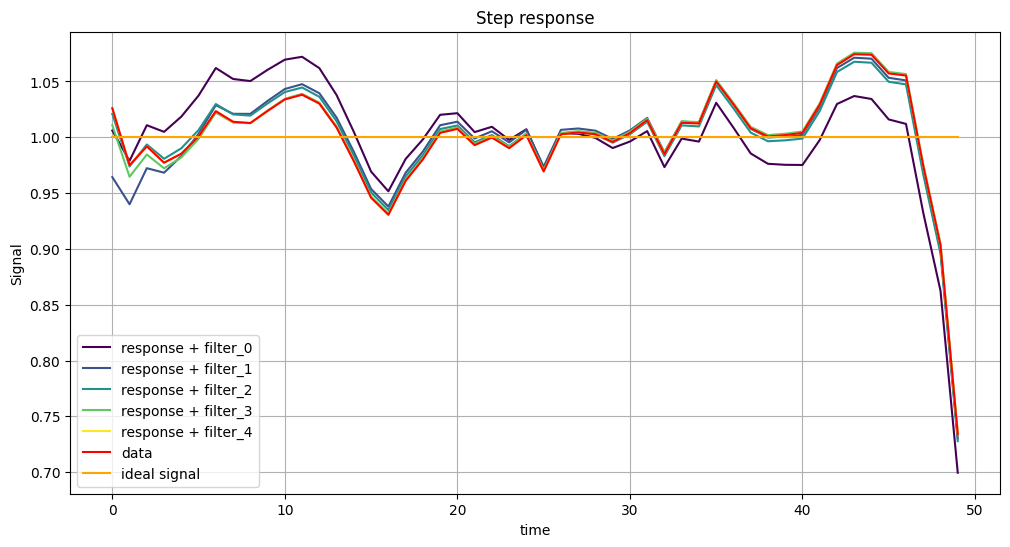

In [16]:
colors = plt.cm.viridis(np.linspace(0, 1, len(responses)))

plt.figure(figsize=(12, 6)) 

for i, resp in enumerate(responses):
    plt.plot(t, resp, color = colors[i], label=f"response + filter_{i}" )
plt.plot(t, step_response, color = "red", label='data')
plt.plot(t, step(t), color = "orange", label="ideal signal" )
plt.xlabel("time")
plt.ylabel("Signal")
plt.title("Step response")
plt.legend()
plt.grid()
plt.show()

In [17]:
new_ref = step_response/model(result.x,t) #new reference data
init_guess = result.x
result = least_squares(residuals, init_guess, args=(t, new_ref))
